# Методы градиентного спуска и Ньютона

Дибель Софья Васильевна, НПМбд-01-19

3. Получить формулы для градиента и гессиана функции логистической регрессии. Выписать их в отчет в матрично-векторной форме с использованием поэлементных функций, но без каких-либо суммирований. Также выписать в отчет выражение для самой функции логистической регрессии в матрично-векторной форме (без явных суммирований).

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import oracles
import optimization
import presubmit_tests as pt
from plot_trajectory_2d import plot_levels, plot_trajectory
from sklearn.datasets import load_svmlight_file

Реализуем подсчет разностных производных (функции grad_finite_diff и hess_finite_diff в модуле oracles). Проверим правильность реализации подсчета градиента и гессиана логистического оракула с помощью реализованных функций. Для этого сгенерируем небольшую модельную выборку (матрицу A и вектор b) и сравним значения, выдаваемые методами grad и hess, с соответствующими разностными аппроксимациями в нескольких пробных точках x.

In [11]:
A = np.array([[1, 2], [3, -4]])
b = np.array([10, 11])
regcoef = 2
oracle = oracles.create_log_reg_oracle(A, b, regcoef)
f = lambda x: oracle.func(x)
x = np.array([1, 2])

for x in np.array([[1, 2], [-1, -2], [3, 0]]):
    print('x =', x)
    print('Градиент через grad:', oracle.grad(x))
    print('Градиент через grad_finite_diff:', oracles.grad_finite_diff(f, x))
    print('Гессиан через hess:')
    print(oracle.hess(x))
    print('Гессиан через hess_finite_diff')
    print(oracles.hess_finite_diff(f, x))
    print()

x = [1 2]
Градиент через grad: [-14.5  26. ]
Градиент через grad_finite_diff: [-14.50000013  25.99999931]
Гессиан через hess:
[[ 2.00000000e+00 -7.79748855e-24]
 [-7.79748855e-24  2.00000000e+00]]
Гессиан через hess_finite_diff
[[ 2.00003569e+00 -7.10542736e-05]
 [-7.10542736e-05  1.99989358e+00]]

x = [-1 -2]
Градиент через grad: [ -7. -14.]
Градиент через grad_finite_diff: [ -6.99999987 -14.00000009]
Гессиан через hess:
[[2.00000000e+00 1.92874985e-22]
 [1.92874985e-22 2.00000000e+00]]
Гессиан через hess_finite_diff
[[1.99996464 0.        ]
 [0.         2.00000017]]

x = [3 0]
Градиент через grad: [ 6.00000000e+00 -9.34807787e-13]
Градиент через grad_finite_diff: [5.99999996 0.        ]
Гессиан через hess:
[[2.00000000e+00 9.34807787e-14]
 [9.34807787e-14 2.00000000e+00]]
Гессиан через hess_finite_diff
[[2.00001793e+00 1.77635684e-05]
 [1.77635684e-05 2.00000017e+00]]



Проверим, что тесты в файле presubmit_tests.py проходят успешно:

In [2]:
pt.test_python3()
pt.test_QuadraticOracle()
pt.test_log_reg_usual()
pt.test_log_reg_oracle_calls()
pt.test_grad_finite_diff_1()
pt.test_grad_finite_diff_2()
pt.test_hess_finite_diff_1()
pt.test_hess_finite_diff_2()
pt.test_line_search()
pt.test_gd_basic()
pt.test_newton_basic()
pt.test_newton_1d()
pt.test_newton_fail()

Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]


## Эксперименты

### Эксперимент 1: Траектория градиентного спуска на квадратичной функции

Проанализируем траекторию градиентного спуска для нескольких квадратичных функций: придумаем две-три квадратичные двумерные функции, на которых работа метода будет отличаться, нарисуем графики с линиями уровня функций и траекториями методов.

In [3]:
def draw(oracle, methods, x_start, descent, tolerance=1e-5, max_iter=10000, trace=False, display=False):
    for i in range(len(methods)):
        fig, ax = plt.subplots(1, len(x_start), figsize=(17, 5))
        s = ''
        for key, val in methods[i].items():
            s = s + str(key) + ': ' + str(val) + ', '
        fig.suptitle(s, fontsize=15)
        plt.subplots_adjust(top=0.85)
        
        for j in range(len(x_start)):
            [x_star, msg, history] = descent(oracle, x_start[j], tolerance=tolerance, max_iter=max_iter, line_search_options = methods[i], trace=trace, display=display)
            plot_levels(oracle.func, ax[j])
            plot_trajectory(oracle.func, ax[j], history['x'])
            ax[j].set_title("x_start: " + str(x_start[j]) + ', iterations: ' + str(len(history['time'])))
            ax[j].legend()

In [4]:
x_start = np.array([[-4., -4.], [2., -4.], [5., 4.]])
methods = [{'method': 'Constant', 'c': 0.1}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1':0.1}, {'method':'Armijo', 'alpha_0':1.0, 'c1':0.4}, 
           {"method":'Wolfe', 'c1':1e-4, 'c2':0.8, 'alpha_0':1.0}, {"method":'Wolfe', 'c1':0.4, 'c2':0.95, 'alpha_0':100.0}]

Первая квадратичная функция: 

Число обусловленности: 2.0000000000000004


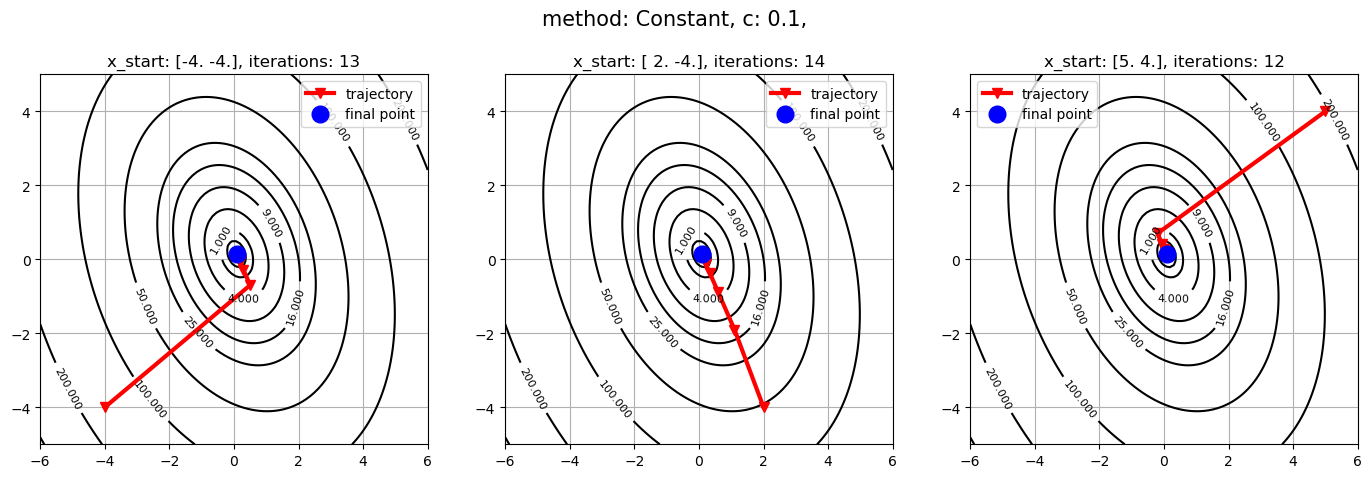

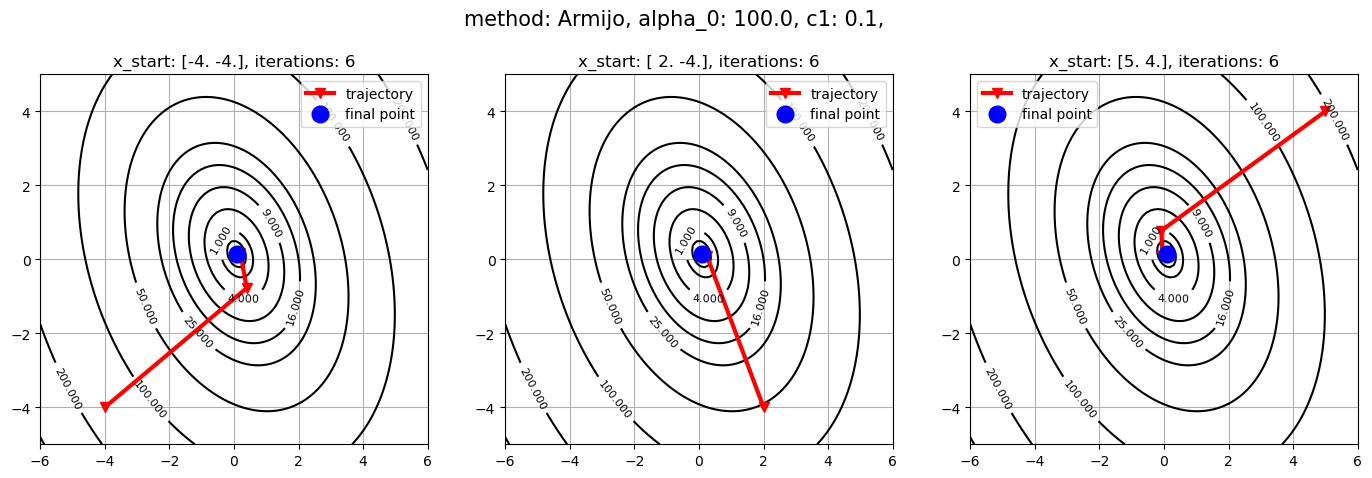

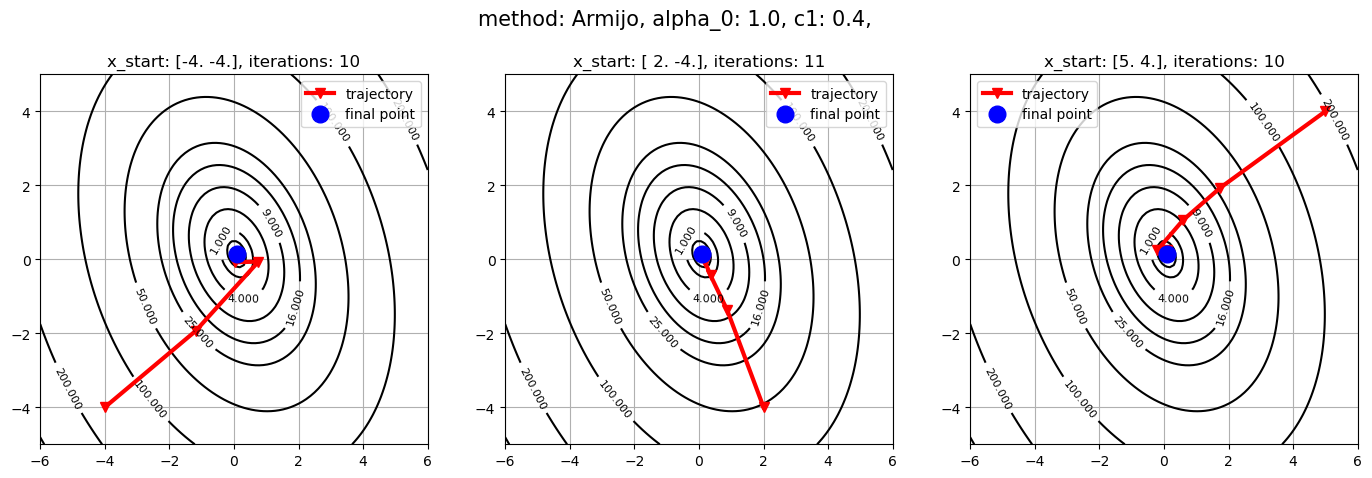

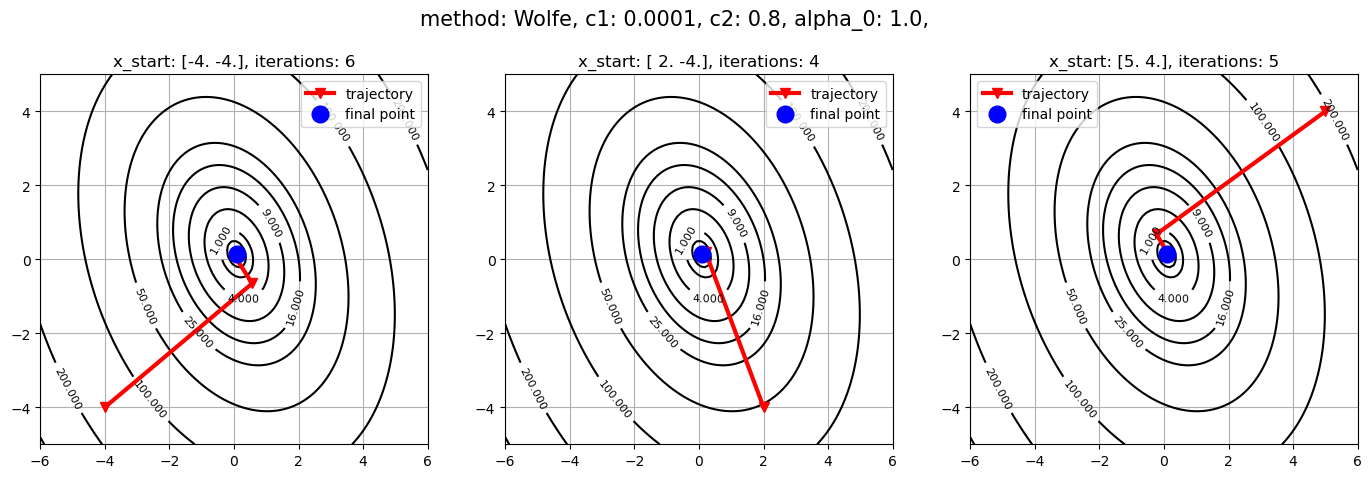

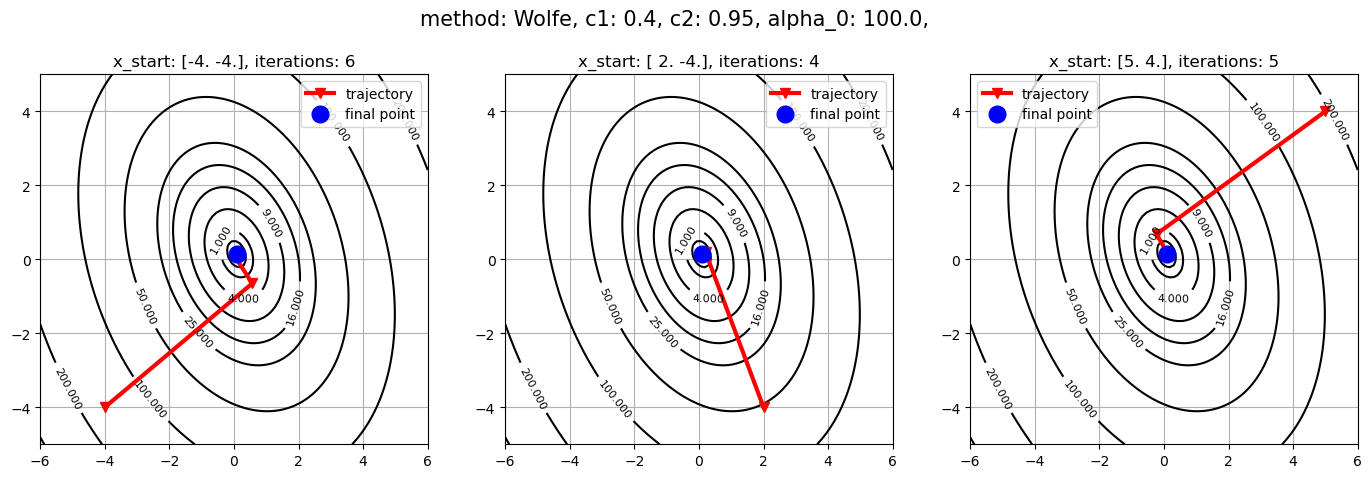

In [5]:
A = np.array([[9., 2.], [2., 6.]])
b = np.array([1., 1.])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.cond(A))

descent = optimization.gradient_descent
draw(oracle, methods, x_start, descent, tolerance=1e-5, max_iter=1000, trace=True, display=False)

Вторая квадратичная функция:

Число обусловленности: 13.288382660794833


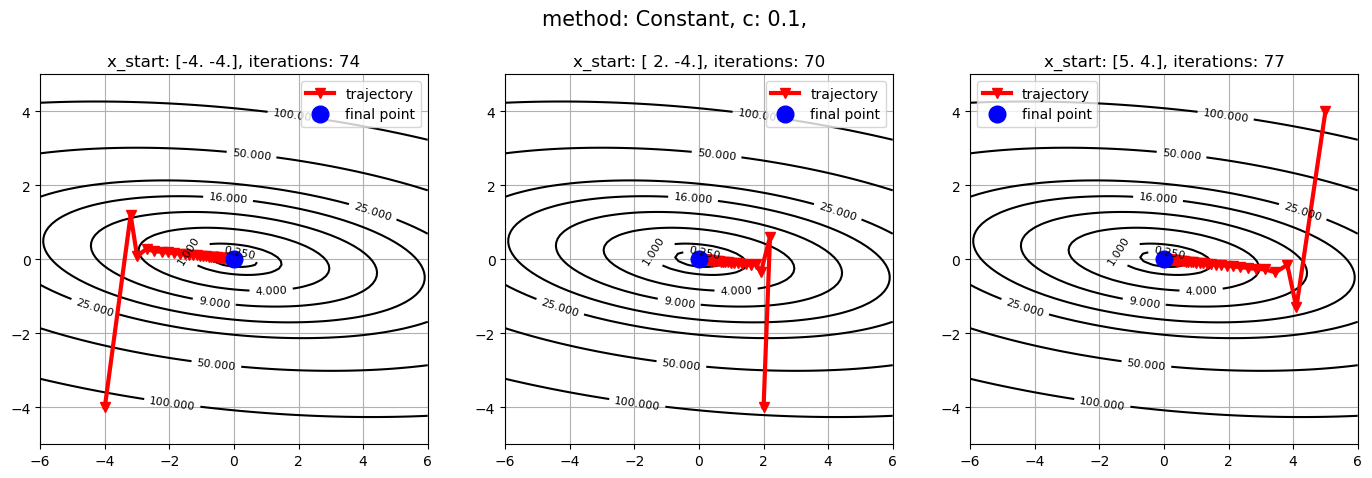

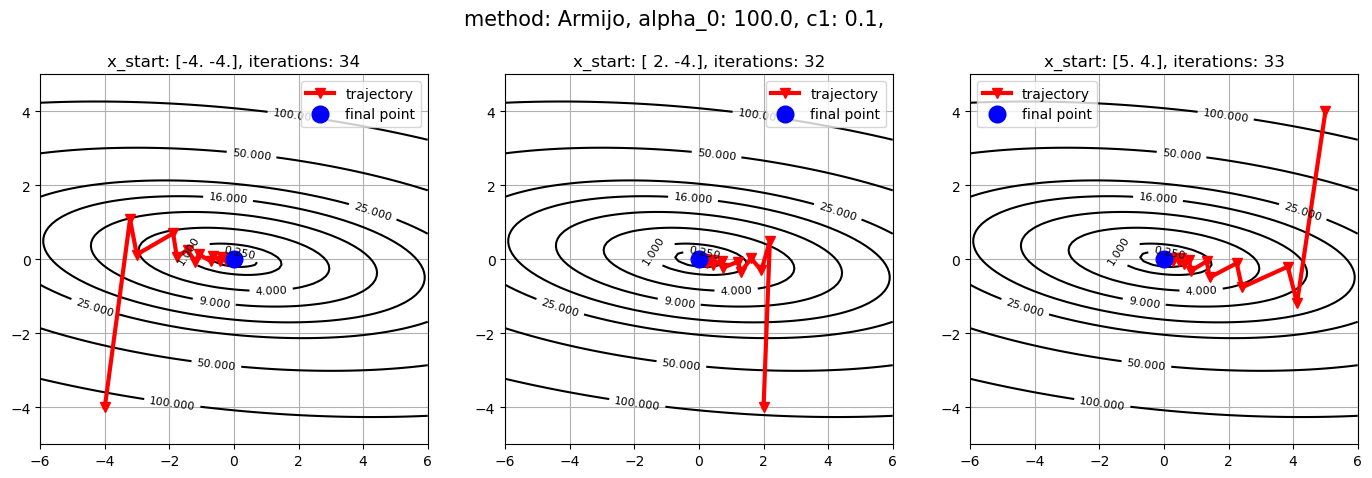

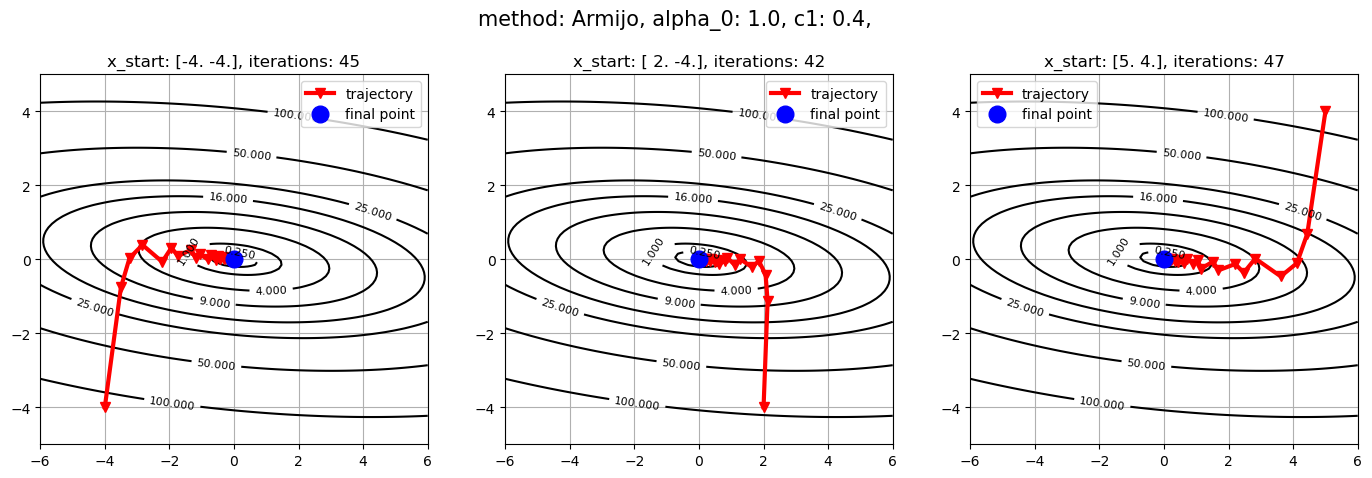

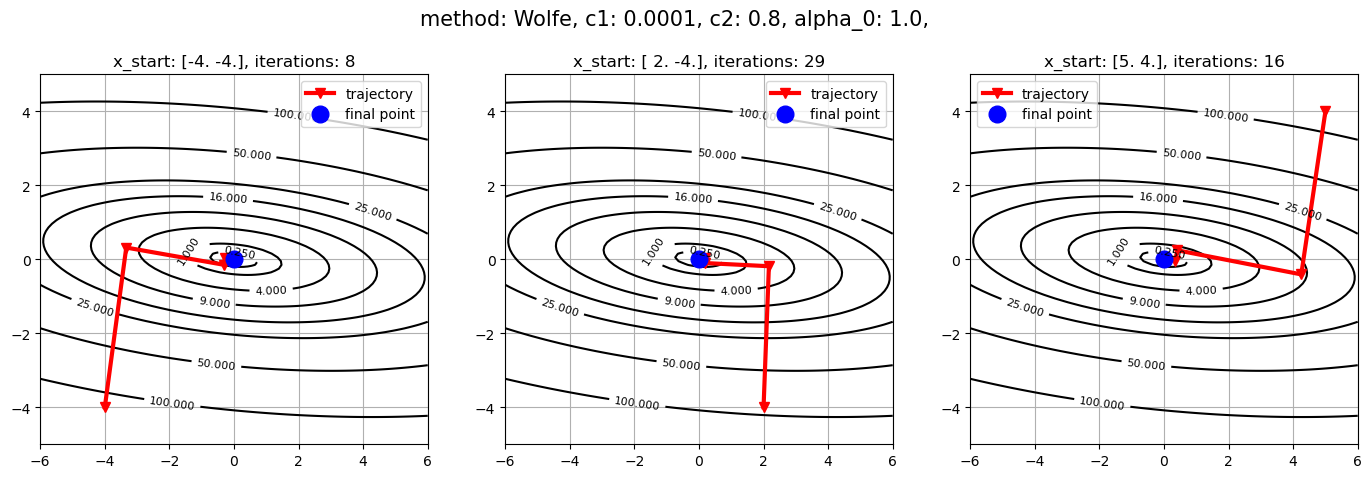

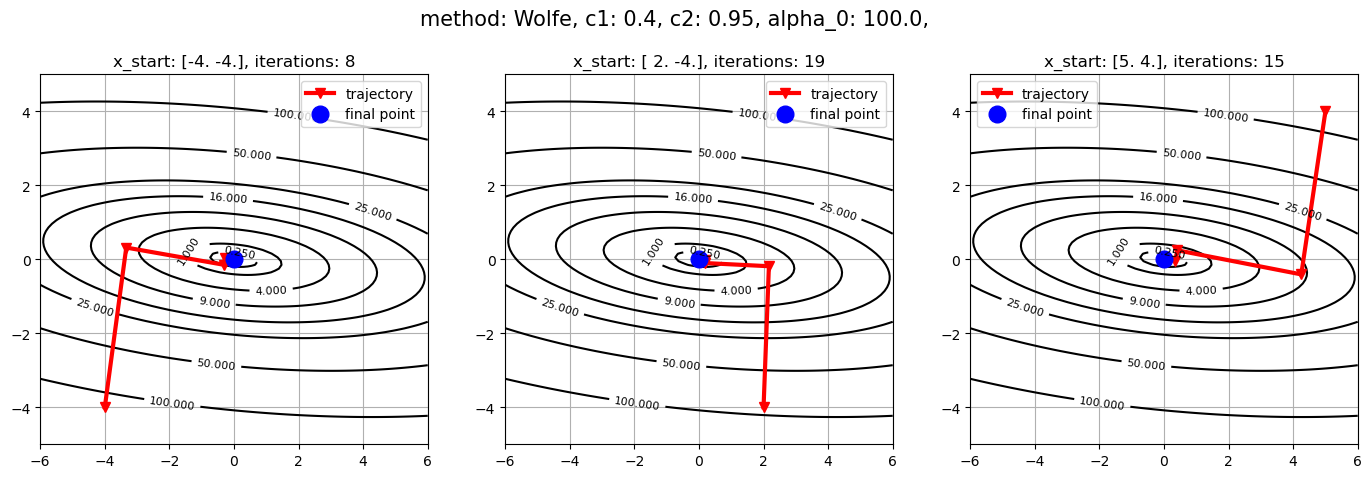

In [6]:
A = np.array([[1.0, 1.0], [1.0, 12.]])
b = np.array([0.0, 0.0])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.cond(A))

descent = optimization.gradient_descent
draw(oracle, methods, x_start, descent, tolerance=1e-5, max_iter=1000, trace=True, display=False)

При большем числе обусловленности требуется больше итераций для спуска.

Чем дальше начальная точка, тем больше итераций потребуется.

Больше всего итераций требуется при константной стратерии выбора шага, меньше всего - при Вульфе.

### Эксперимент 2: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства


Исследуем, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров: 1) числа обусловленности κ ≥ 1 оптимизируемой функции и 2) размерности пространства n оптимизируемых переменных.

Для этого для заданных параметров n и κ сгенерируем случайным образом квадратичную задачу размера n с числом обусловленности κ и запустим на ней градиентный спуск с некоторой фиксированной требуемой точностью. Замерим число итераций T(n,κ), которое потребовалось сделать методу до сходимости (успешному выходу по критерию остановки).

Зафиксируем некоторое значение размерности n. Переберем различные числа обусловленности κ по сетке и построим график зависимости T(κ,n) против κ. Поскольку каждый раз квадратичная задача генерируется случайным образом, то повторим этот эксперимент несколько раз. В результате для фиксированного значения n у нас получится целое семейство кривых зависимости T(κ,n) от κ. Нарисуем все эти кривые одним и тем же цветом для наглядности.

Теперь увеличим значение n и повторим эксперимент снова. Получим новое семейство кривых T(n′,κ) против κ. Нарисуем их все одним и тем же цветом, но отличным от предыдущего (например, синим).

Повторим эту процедуру несколько раз для других значений n. В итоге получим несколько разных семейств кривых — часть красных (соответствующих одному значению n), часть синих (соответствующих другому значению n), часть зеленых и т. д.

Обратим внимание, что значения размерности n имеет смысл перебирать по логарифмической сетке (например, n = 10, n = 100, n = 1000 и т. д.).

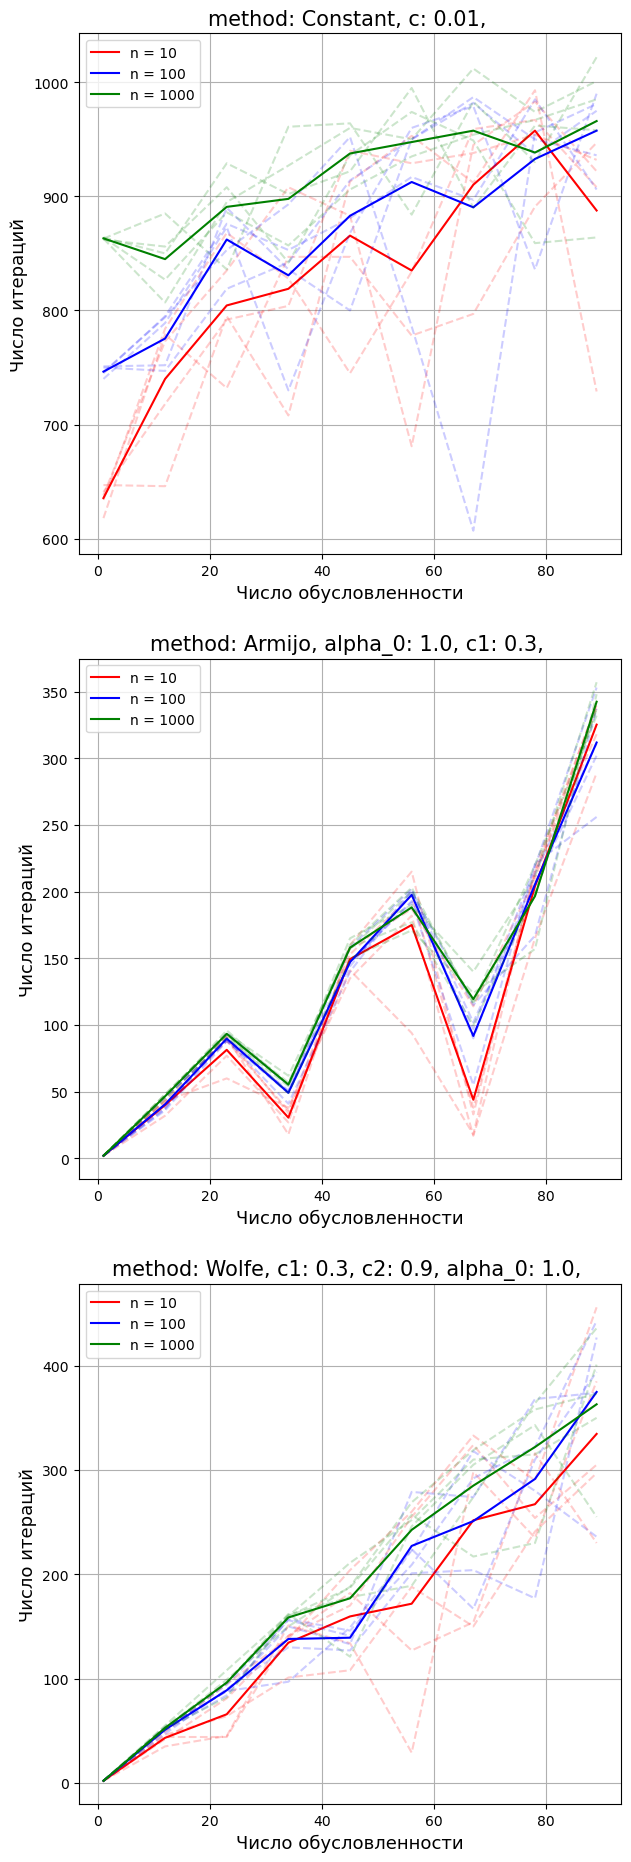

In [14]:
options = [(10, 'r'), (100, 'b'), (1000, 'g')]
K = np.arange(1, 100, 11)
methods = [{'method': 'Constant', 'c': 0.01}, 
           {'method': 'Armijo', 'alpha_0': 1.0, 'c1': 0.3}, 
           {"method": 'Wolfe', 'c1': 0.3, 'c2': 0.9, 'alpha_0': 1.0}]

fig, ax = plt.subplots(3, 1, figsize=(7, 23))

for i in range(len(methods)):
    for n, colour in options:
        I = np.zeros(len(K))
        number_of_experiments = 5
        for j in range(number_of_experiments):
            it = []
            for k in K:
                a = np.random.uniform(1, k, n)
                a[0] = 1.
                a[-1] = k
                A = scipy.sparse.diags(a)
                b = np.random.rand(n) * k
                oracle = oracles.QuadraticOracle(A, b)
                x_star, msg, history = optimization.gradient_descent(oracle, np.ones(n), 
                                                              line_search_options=methods[i], trace=True)
                if msg != "success":
                    print(msg)
                it.append(len(history['time']))
            I += np.array(it)
            ax[i].plot(K, it, color=colour, linestyle='dashed', alpha=0.2)
        ax[i].plot(K, I / number_of_experiments, color=colour, label=('n = '+str(n)))
        ax[i].legend()
        ax[i].set_xlabel("Число обусловленности", fontsize=13)
        ax[i].set_ylabel("Число итераций", fontsize=13)
        s = ''
        for key, val in methods[i].items():
            s = s + str(key) + ': ' + str(val) + ', '
        ax[i].set_title(s, fontsize=15)
        ax[i].grid()

В среднем, с увеличением числа обусловленности растет число итераций. Причем растет одинаково для всех размерностей, разве что для константного метода можно заметить, что преимущественно итераций больше там, где размерность больше.

### Эксперимент 3: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравним методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используем следующие три набора с сайта LIBSVM3: w8a, gisette и real-sim. Коэффициент регуляризации возьмем стандартным образом: λ = 1/m.

Параметры обоих методов возьмем равными параметрам по умолчанию. Начальную точку выберем $x_0$ = 0.

Построим графики сходимости следующих двух видов:
- Зависимость значения функции от реального времени работы метода.
- Зависимость относительного квадрата нормы градиента $∥∇f(x_k)∥^2_2/∥∇f(x_0)∥^2_2$ (в логарифмической шкале) против реального времени работы.


In [2]:
def graph_compare(svm_file):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    A, b = load_svmlight_file(svm_file)
    regcoef = 1 / len(b)
    oracle = oracles.create_log_reg_oracle(A, b, regcoef)
    
    _, _, history_gd = optimization.gradient_descent(oracle, np.zeros(A.shape[1]), trace=True)
    ax[0].plot(history_gd['time'], history_gd['func'], label='Градиентный спуск')

    _, _, history_n = optimization.newton(oracle, np.zeros(A.shape[1]), trace=True)
    ax[0].plot(history_n['time'], history_n['func'], label='Метод Ньютона')
    
    ax[0].set_xlabel('Реальное время работы метода')
    ax[0].set_ylabel('Значение функции')
    ax[0].legend()

    ax[1].plot(history_gd['time'], np.array(history_gd['grad_norm']) ** 2 / history_gd['grad_norm'][0] ** 2, label="Градиентный спуск")
    ax[1].plot(history_n['time'], np.array(history_n['grad_norm']) ** 2 / history_n['grad_norm'][0] ** 2, label="Метод Ньютона")
    
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Реальное время работы метода')
    ax[1].set_ylabel('Относительный квадрат нормы градиента')
    ax[1].legend()

Сравнение методов для данных из w8a:

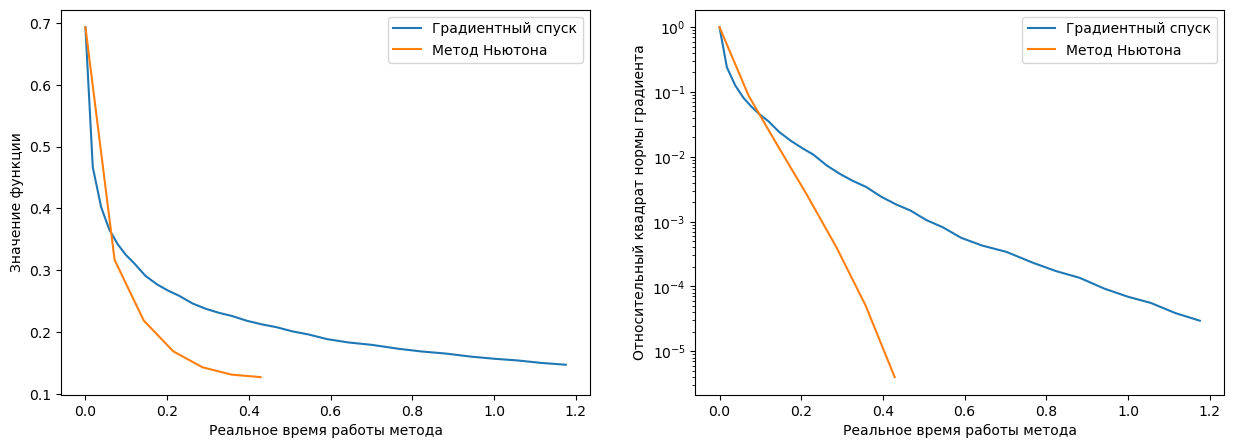

In [7]:
graph_compare('данные/w8a.txt')

Сравнение методов для данных из gisette_scale.t:

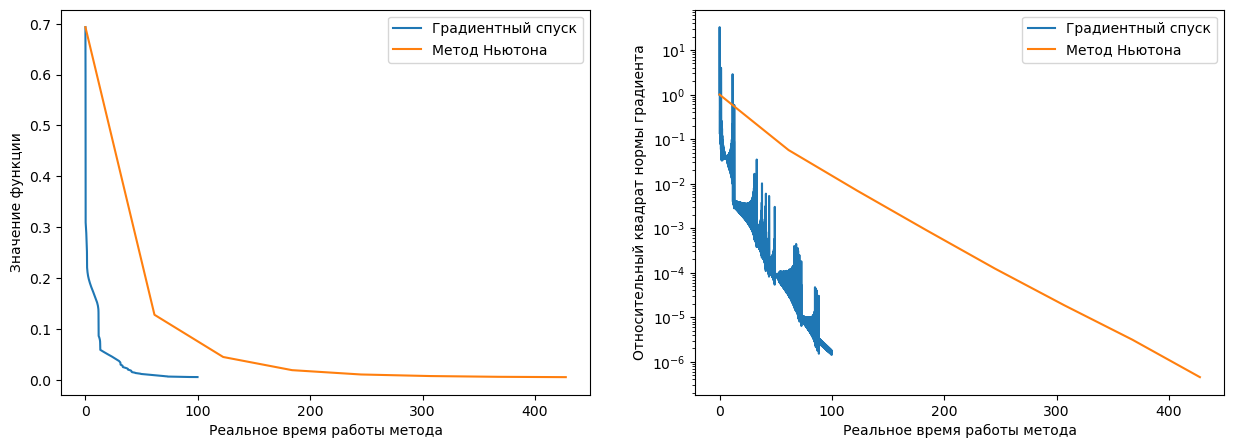

In [11]:
graph_compare('данные/gisette_scale.t.bz2')

Сравнение методов для данных из gisette_scale:

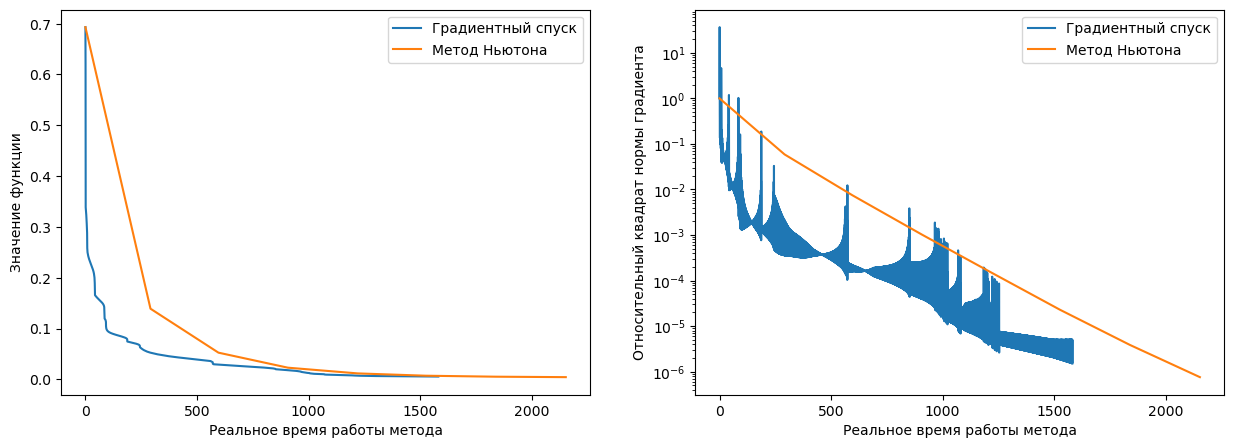

In [12]:
graph_compare('данные/gisette_scale.bz2')

Сравнение методов для данных из real-sim:

/Users/sofia.dibel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


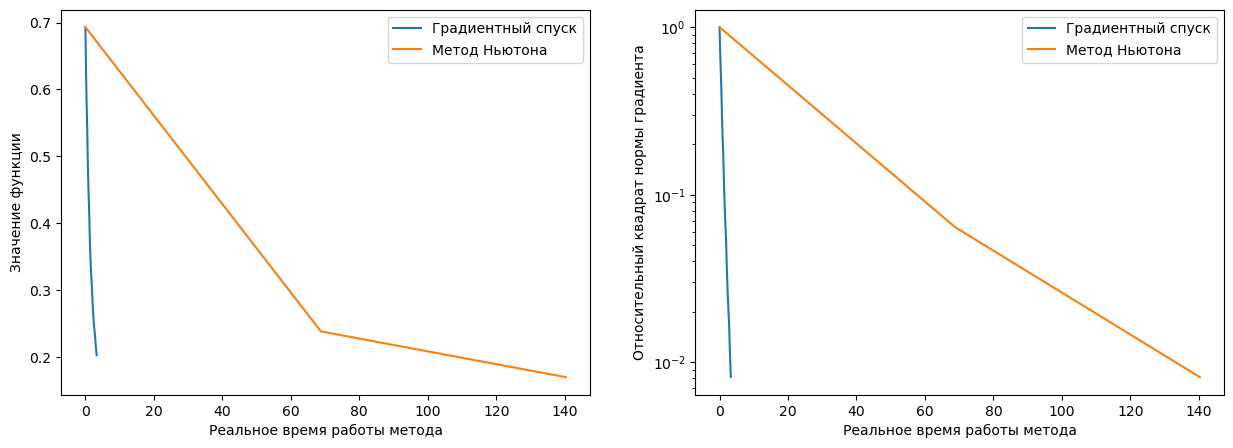

In [9]:
graph_compare('данные/real-sim.bz2')

В данных w8a градиентный спуск быстрее работает в начале (для небольшой точности), но медленнее в конце (для большой точности). В других случаях градиентный спуск сработал быстрее.